<div style="text-align:center">
    
# Grayscale to Color Image Conversion Using Autoencoders

### Mt. SAC CISB 62 Final Project Fall 2023

#### By
    
#### Paul Sandeen
    
</div>

## Introduction

An autoencoder is a type of neural network architecture with two components. The first part is an <i>encoder</i> that accepts input data and reduces the number of dimensions by learning the most critical features. The second part is the <i>decoder</i> that accepts the lower-dimension data and reconstructs the original data.

This project uses an autoencoder to convert grayscale images to color images.  A public data set containing pairs of grayscale images and matching color images is used for training. The autoencoder will accept the grayscale images as input and try create an output that closely matches the corresponding color images. A loss function is used to measure the difference between the generated color image and the actual color image in the data set.


## Intended Audience

This project is intended for students, educators, researchers and anyone interested in understanding how autoencoders can be used to convert grayscale images to color images. Basic familiarity with the Python programming language is required; familiarity with the concepts of neural networks in general and encoder/decoder archtecture specifically and their implementation in the Python libraries Kersas and TensorFlow is assumed.

## Materiels and Methods

This project uses the Python programming language running in the Anaconda environment. 

Associated Python data science libraries: Numpy, pandas, Matplotlib, Seaborn.

Associated Python deep learning libraries: TensorFlow and Keras.

The project was composed as a Jupyter Notebook.


## Data Source

The image files used for this project:

“Landscape color and grayscale images”

Filename: archive.zip; Size: ~200MB

https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization

## Acquire the Necessary Software Packages

In [1]:
# Import the Python file manipulation libraries
import os
import shutil
import glob

In [2]:
# Import random for random numbers
import random

In [3]:
# Import the Python Data Science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Import the Python scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [5]:
# Import the Python deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
import keras_tuner as kt 
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.layers import Input, Dense, Reshape
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Conv2D, UpSampling2D
from tensorflow.keras.models import Model

from minisom import MiniSom

from tensorboard.plugins.hparams import api as hp
import pydot
import graphviz

In [6]:
# Disable warnings in the Jupyter notebook
import warnings
warnings.filterwarnings('ignore')

## Load the Image Data Set

In [7]:
# Set the directory paths for the image data
grayscale_dir = "data/landscapes/gray"
color_dir = "data/landscapes/color"

In [8]:
# Create a function to load the images
def load_images(directory):
    images = []
    for filename in os.listdir(directory): 
        img_path = os.path.join(directory, filename)
        try:
            img = plt.imread(img_path)
            images.append(img)
        except Exception as e:
            print(f"Error: {e}:Unable to read image: {img_path}.")
    return images

In [9]:
# Load the grayscale images
grayscale_images = load_images(grayscale_dir)

In [10]:
# Load the color images
color_images = load_images(color_dir)

## Exploratory Data Analysis (EDA)

#### Display a sample of the image data

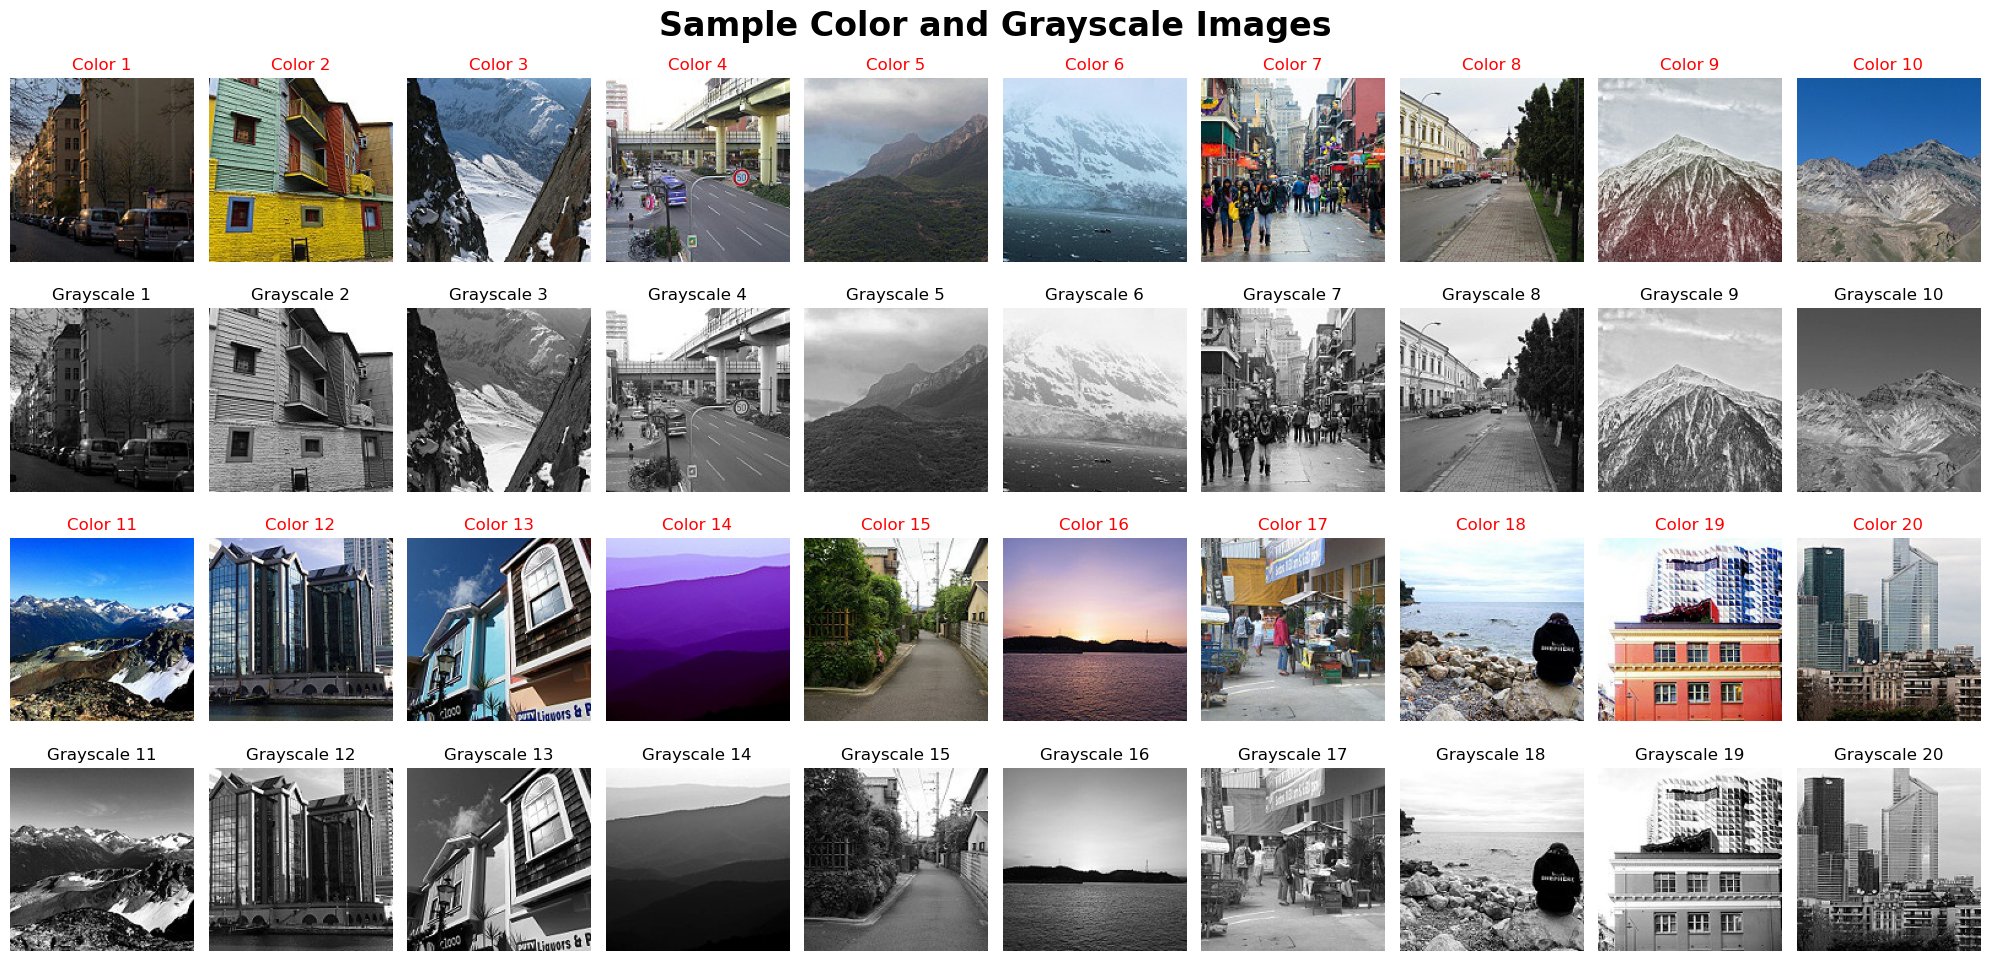

In [11]:
# Displaying color and grayscale images side by side
fig, axs = plt.subplots(4, 10, figsize=(20, 10))

# Display color images 1-10
for i, img in enumerate(color_images[0:10]):
    axs[0, i].imshow(img)
    axs[0, i].axis('off')
    axs[0, i].set_title(f"Color {i+1}", color='red')

# Display color images 11-20
for i, img in enumerate(color_images[10:20]):
    axs[2, i].imshow(img)
    axs[2, i].axis('off')
    axs[2, i].set_title(f"Color {i+11}", color='red')

# Display grayscale images 1-10
for i, img in enumerate(grayscale_images[0:10]):
    axs[1, i].imshow(img, cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title(f"Grayscale {i+1}")

# Display grayscale images 11-20
for i, img in enumerate(grayscale_images[10:20]):
    axs[3, i].imshow(img, cmap='gray')
    axs[3, i].axis('off')
    axs[3, i].set_title(f"Grayscale {i+11}")

# Use a title, tight layout and show the images
plt.suptitle("Sample Color and Grayscale Images", fontsize=24, fontweight='bold')
plt.tight_layout()
plt.show()


<b>Result Interpretation:</b> The pictures show images of landscapes: buildings, mountains, streets, sunsets, and people. 

#### Display information about the images

In [12]:
# Display the number of color and graycale images
print(f"Number of color images: {len(color_images):,}")
print(f"Number of grayscale images: {len(grayscale_images):,}")

Number of color images: 7,129
Number of grayscale images: 7,129


In [13]:
# Display color image information
img = color_images[0]
color_width, color_height, color_channels = img.shape
print(f"Color image size: {color_width} pixels x {color_height} pixels; number of channels: {color_channels}")


Color image size: 150 pixels x 150 pixels; number of channels: 3


In [14]:
# Display grayscale image information
img = grayscale_images[0]
grayscale_width, grayscale_height = img.shape
grayscale_channels = 1
print(f"Grayscale image size: {grayscale_width} pixels x {grayscale_height} pixels; number of channels: {grayscale_channels}")

Grayscale image size: 150 pixels x 150 pixels; number of channels: 1


In [15]:
# Remove grayscale images that are not the standanrd dimension
orig_length = len(grayscale_images)
count = 0
for img in grayscale_images:
    if img.shape != (150, 150):
        grayscale_images.remove(img)
        count+= 1

print(f"Removed {count} images from the origial {orig_length} data set.")

Removed 23 images from the origial 7129 data set.


In [16]:
# Remove color images that are not the standanrd dimension
orig_length = len(color_images)
count = 0
for img in color_images:
    if img.shape != (150, 150, 3):
        color_images.remove(img)
        count+= 1

print(f"Removed {count} images from the origial {orig_length} data set.")

Removed 23 images from the origial 7129 data set.


### Part 1: Deep Learning with Autoencoders

<b>Goal</b>: Train an  autoencoder using a convolutional neural network to colorize grayscale images.

#### Find the shape of the images

In [17]:
# Determine the grayscale image input shape
grayscale_input_shape = (grayscale_height, grayscale_width, grayscale_channels)
print(f"Grayscale image shape: {grayscale_input_shape}")

Grayscale image shape: (150, 150, 1)


#### Build the encoder portion of the autoencoder

In [18]:
# Create the convolutional encoder
inputs = Input(shape=grayscale_input_shape)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((3, 3), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

#### Build the decoder portion of the autoencoder

In [19]:
# Create the convolutional decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((3, 3))(x)

decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(x)

#### Build and compile the model

In [20]:
# Createt the autoencoder model
autoencoder = Model(inputs, decoded)

In [21]:
# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])

#### Display a summary of the autoencoder model

In [22]:
# Print the autoencoder model summary
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 16)        1168  

#### Convert the Python list storing the images to NumPy arrays and normalize the images

In [23]:
# Convert the Python list of images to numpy arrays
grayscale_np = np.array(grayscale_images)
color_np = np.array(color_images)

In [24]:
# Process the grayscale and color images
grayscale_scaled = grayscale_np / 255.0
color_scaled = color_np / 255.0


In [25]:
# Reshape the grayscale images to the same size as the input shape
grayscale_images = grayscale_scaled.reshape((len(grayscale_scaled), grayscale_height, grayscale_width, 1))

#### Fit (train) the model

In [26]:
# Train (fit) the autoencoder model
history = autoencoder.fit(grayscale_scaled, color_scaled,
                          epochs=10,
                          batch_size=16,
                          shuffle=True)

Epoch 1/10
445/445 [==============================] - 268s 595ms/step - loss: 0.6471 - mse: 0.0418
Epoch 2/10
445/445 [==============================] - 257s 577ms/step - loss: 0.5629 - mse: 0.0221
Epoch 3/10
445/445 [==============================] - 252s 565ms/step - loss: 0.5594 - mse: 0.0207
Epoch 4/10
445/445 [==============================] - 250s 561ms/step - loss: 0.5575 - mse: 0.0199
Epoch 5/10
445/445 [==============================] - 250s 563ms/step - loss: 0.5571 - mse: 0.0198
Epoch 6/10
445/445 [==============================] - 250s 563ms/step - loss: 0.5558 - mse: 0.0193
Epoch 7/10
445/445 [==============================] - 251s 563ms/step - loss: 0.5549 - mse: 0.0190
Epoch 8/10
445/445 [==============================] - 250s 562ms/step - loss: 0.5544 - mse: 0.0188
Epoch 9/10
445/445 [==============================] - 251s 563ms/step - loss: 0.5540 - mse: 0.0186
Epoch 10/10
445/445 [==============================] - 251s 564ms/step - loss: 0.5538 - mse: 0.0185


#### Use the trained model to predict (colorize) 10 grayscale images

In [27]:
# Colorize 10 grayscale images
colorized_images = []
for img in grayscale_scaled[0:10]:
    img = img.reshape((1, 150, 150, 1))
    predicted_color_image = autoencoder.predict(img)
    colorized_images.append(predicted_color_image)

1/1 [==============================] - 0s 48ms/step


#### Compare the original color and grayscale images with the generated images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


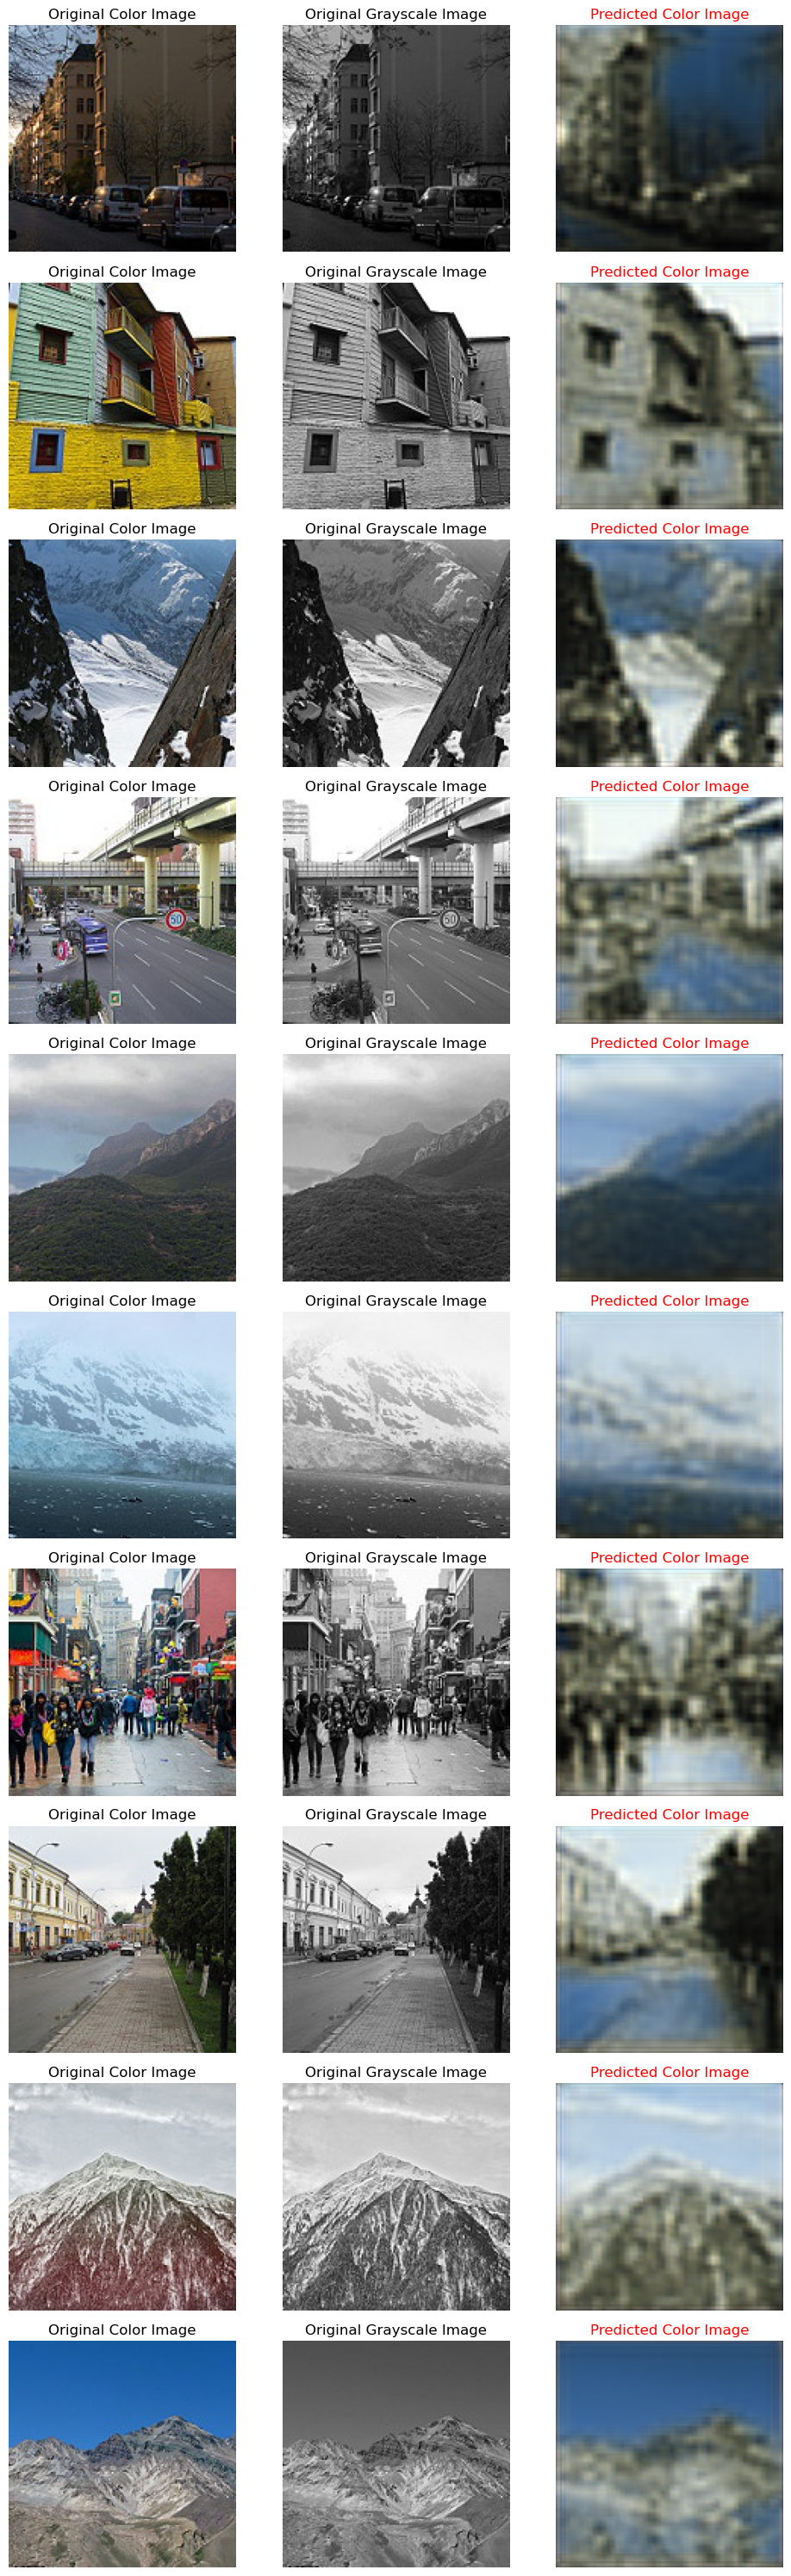

In [28]:
# Compare the oringal color image, original grayscale image, and regenerated color images

num_images = 10
plt.figure(figsize=(10, 30))

for i in range(num_images):
    # Display the original color image
    plt.subplot(num_images, 3, i * 3 + 1)
    plt.imshow(color_scaled[i])
    plt.title('Original Color Image')
    plt.axis('off')

    # Display the original grayscale image
    plt.subplot(num_images, 3, i * 3 + 2)
    plt.imshow(grayscale_scaled[i], cmap='gray')
    plt.title('Original Grayscale Image')
    plt.axis('off')

    # Display the predicted color image
    plt.subplot(num_images, 3, i * 3 + 3)
    plt.imshow(colorized_images[i].squeeze()) # Convert shape to (150, 150, 3)
    plt.title('Predicted Color Image', color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()

<b>Result Interpretation</b>: The predicted color images produced by the encoder did reproduce colors close to the original color photos in the green and blue color gamut, but lost accuracy in the red gamut. The images also lost sharpness and appear ‘blurry.’

There are several image processing techniques that can be used to improve the image quality, including contrast enhancement or histogram equalization that can be done in the image preprocessing stage. 

A significant amount of time went into tuning the hyperparameters of the convolutional neural networks, including the number of layers, the number of neurons and the use of MaxPooling and UpSampling. The effect of adding Dropout was also tested. The end result was that adding more layers or more neurons or more features actually hurt the autoencoder performance by making the images increasingly blurry.

Another consideration is the fact that the encoder must be ‘mirrored’, meaning that the dimensions of the input to the encoder must be the same as the output of the decoder, which can be difficult to do when investigating the combination of layers and neurons in the encoder or decoder will provide the best predicted color image. 



## Part 2: Deep Learning with Clustering and the SOM

<b>Explanation</b>: A Self-Organizing Map (SOM) is a technique used in deep learning for data dimensionality reduction and clustering. The SOM is designed to for clustering data while the input data point remain close to each other in the map.

#### Extract the first color image and examine its details

In [29]:
# Use the first colorized image and store it in the standard dimensions
# image1 = colorized_images[1].squeeze()
image1 = color_scaled[1]

In [30]:
#Display the size of the first colorized image
image1.shape

(150, 150, 3)

In [31]:
# Display the contents of the image data
image1[0][0]

array([0.08627451, 0.11372549, 0.1372549 ])

<b>Note</b>: The image data is already scaled from 0-1.

#### Flatten the image

In [32]:
# Flatten the image 
flattened_image1 = np.reshape(image1, (image1.shape[0]*image1.shape[1], 3))

# Display the flattened image shape
flattened_image1.shape

(22500, 3)

#### Initialize and train the SOM

In [33]:
# Define the parameters for the SOM
som_width = 3
som_height = 3

input_len = flattened_image1.shape[1]  # Flattened image size
sigma = 1.0                            # Initial neighborhood radius
learning_rate = 0.5                    # Initial learning rate


In [34]:
# Train the SOM
print('Training the SOM...')
som = MiniSom(som_width, som_height, input_len, 
              sigma=sigma, 
              learning_rate=learning_rate,
              neighborhood_function='bubble')
som.random_weights_init(flattened_image1)
starting_weights = som.get_weights().copy()  # saving the starting weights
som.train(flattened_image1, 5_000, random_order=True, verbose=True)

Training the SOM...


 [ 1961 / 5000 ]  39% - 0:00:00 left 

 [ 3449 / 5000 ]  69% - 0:00:00 left 

 [ 4729 / 5000 ]  95% - 0:00:00 left 

 [ 5000 / 5000 ] 100% - 0:00:00 left 


 quantization error: 0.12488155993370324


<b>Note</b>: The quantiziation error (QE) is the difference between the input data and the best matching unit (BMU) determined by the SOM. The BMU is the node in the SOM grid closest to the input data.


#### Use SOM quantization to build a new image

In [35]:
print('Quantization...')
qnt = som.quantization(flattened_image1)  # quantize each pixels of the image

print('Building the new image...')
clustered = np.zeros(image1.shape)

for i, q in enumerate(qnt):  # Place the quantized values into a new image
    clustered[np.unravel_index(i, shape=(image1.shape[0], image1.shape[1]))] = q

print('Quantization done.')

Quantization...
Building the new image...
Quantization done.


#### Plot the colorized image and the SOM-Quantized Result

(-0.5, 2.5, 2.5, -0.5)

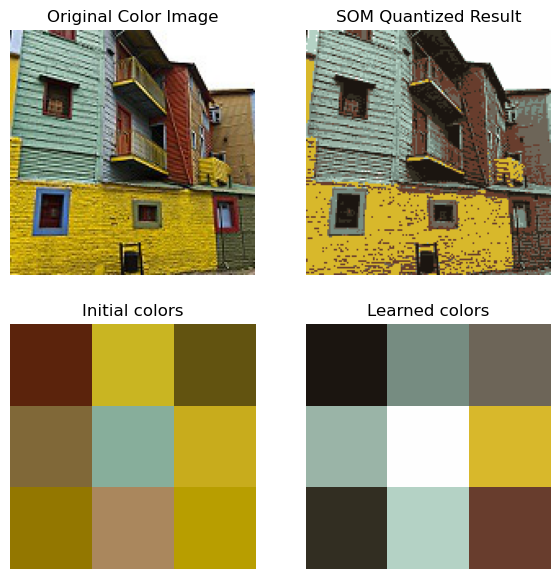

In [36]:
# Configure the plot
plt.figure(figsize=(7, 7))
plt.figure(1)

# Plot the original image
plt.subplot(221)
plt.title('Original Color Image')
plt.imshow(image1)
plt.axis('off')

# Plot the SOM-quantized result
plt.subplot(222)
plt.title('SOM Quantized Result')
plt.imshow(clustered)
plt.axis('off')

# Display the original image colors
plt.subplot(223)
plt.title('Initial colors')
plt.imshow(starting_weights, interpolation='none')
plt.axis('off')

# Display the learned colors
plt.subplot(224)
plt.title('Learned colors')
plt.imshow(som.get_weights(), interpolation='none')
plt.axis('off')

<b>Result interpretation</b>: The autoencoder had difficulty recreating the red color gamut, but did well on the green and blue color gamut. This image was selected specifically because it had yellow and red colors to demonstrate the color extraction capability of the SOM. Notice that the SOM was able to find the region with red color, but it became brown or beige in the learned color palette. Also two of the yellow shades were replaced by colors with a green hue.

There are two reasons why the color red is difficult to detect. The first is that red is not a common color in the pictures used in the data set, which means that the neural network may not have had the chance to get adequately trained to recognize that color. 

The second reason red might be difficult to detect is that red is only one-third of the RGB color space, while green and blue make up two-thirds. This means the data set is biased toward green and blue, and against red.

## Part 3: Deep Learning with TensorBoard

<b>Explanation</b>: TensorBoard is a tool provided with TensorFlow and is used to visualize deep learning models. TensorBoard provides graphing tools to monitor model performance characteristics including training metrics.

TensorBoard will be used to compare two optimizers, ‘adam’ (Adaptive Moment Estimation) and ‘sgd’ (Stochastic Gradient Descent). Unlike SGD, Adam is adaptive and adjusts learning rates to reach converge to minimize the loss function. 

#### Load the TensorBoard environment

In [37]:
# Load the TensorBoard extension for Jupyter notebooks
%load_ext tensorboard

#### Delete TensorBoard log files and data directories from previous runs

In [38]:
# Remove logs from previous TensorBoard runs

folder_path = "logs/"

# Check if the folder exists before attempting to delete it
if os.path.exists(folder_path):
    # Remove the folder and its contents recursively
    shutil.rmtree(folder_path)
    print(f"The folder '{folder_path}' has been deleted.")
else:
    print(f"The folder '{folder_path}' does not exist.")

The folder 'logs/' has been deleted.


In [39]:
# Remove the ".tensorboard-info" directory from previous TensorBoard runs

folder_path = "C:/Users/psand/AppData/Local/Temp/.tensorboard-info/"

# Check if the folder exists before attempting to delete it
if os.path.exists(folder_path):
    # Remove the folder and its contents recursively
    shutil.rmtree(folder_path)
    print(f"The folder '{folder_path}' has been deleted.")
else:
    print(f"The folder '{folder_path}' does not exist.")

The folder 'C:/Users/psand/AppData/Local/Temp/.tensorboard-info/' does not exist.


#### Define the hyperparameter to configure

In [40]:
# Define the optimizer configuration
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

In [41]:
# Define the accuracy metric
METRIC_ACCURACY = 'accuracy'

In [42]:
# Write the metrics to the log file
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(hparams=[HP_OPTIMIZER], metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

#### Compile the model from Part 1 with the TensorBoard optimizer settings


In [43]:
# Train and test the model
def train_test_model(hparams):

    # Compile the autoencoder
    autoencoder.compile(optimizer=hparams[HP_OPTIMIZER], loss='binary_crossentropy', metrics=['accuracy'])

    # Save the model graph to TensorBoard
    tf.keras.utils.plot_model(autoencoder, to_file='logs/hparam_tuning/model.png', show_shapes=True)

    # Train/fit the autoencoder
    autoencoder.fit(grayscale_scaled, color_scaled, validation_data=(grayscale_scaled[:10], color_scaled[:10]),
                epochs=5,
                batch_size=16)

    # Determine the autoencoder accuracy
    metric_accuracy, accuracy = autoencoder.evaluate(grayscale_scaled[:10], color_scaled[:10])
        
    return accuracy

In [44]:
# Invoke the model
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [45]:
# Start the log runs
session_num = 0

for optimizer in HP_OPTIMIZER.domain.values:
    hparams = {
        HP_OPTIMIZER: optimizer,
    }
    run_name = "run-%d" % session_num
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    run('logs/hparam_tuning/' + run_name, hparams)
    session_num += 1

--- Starting trial: run-0
{'optimizer': 'adam'}
Epoch 1/5
445/445 [==============================] - 258s 574ms/step - loss: 0.5541 - accuracy: 0.4380 - val_loss: 0.5643 - val_accuracy: 0.3017
Epoch 2/5
445/445 [==============================] - 269s 605ms/step - loss: 0.5536 - accuracy: 0.4401 - val_loss: 0.5645 - val_accuracy: 0.4235
Epoch 3/5
445/445 [==============================] - 276s 621ms/step - loss: 0.5528 - accuracy: 0.4465 - val_loss: 0.5635 - val_accuracy: 0.4821
Epoch 4/5
445/445 [==============================] - 286s 642ms/step - loss: 0.5525 - accuracy: 0.4474 - val_loss: 0.5628 - val_accuracy: 0.4834
Epoch 5/5
1/1 [==============================] - 0s 162ms/step - loss: 0.5641 - accuracy: 0.4690
--- Starting trial: run-1
{'optimizer': 'sgd'}
Epoch 1/5
445/445 [==============================] - 279s 621ms/step - loss: 0.5512 - accuracy: 0.4537 - val_loss: 0.5624 - val_accuracy: 0.4333
Epoch 2/5
445/445 [==============================] - 272s 612ms/step - loss: 0.5511

#### Start TensorBoard

In [47]:
# Visualize the TensorBoard Results
%tensorboard --logdir logs/hparam_tuning

Reusing TensorBoard on port 6006 (pid 14208), started 0:13:39 ago. (Use '!kill 14208' to kill it.)

 <b>Result Interpretation</b>: Adam performed slightly better than SGD and both required approximately the same compute time. Using TensorBoard, there was minimal measurable difference between the Adam and SGD optimizers.

#### Use TensorBoard to visualize the convolutional model

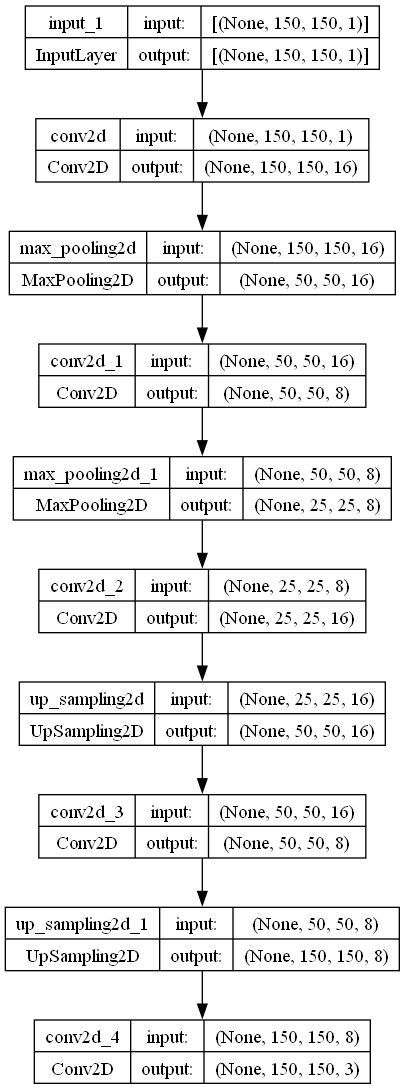

<b>Model Interpretation</b>: TensorBoard can be used to create a visual representation of the convolutional autoencoder model. Note that the dimensions on the input  (None, 150, 150, 1) had to match the dimensions on the output (None, 150, 150, 3) except the 1 and the 3 will reflect the fact that the encoder will take the grayscale image with one ‘intensity’ channel as input and the decoder will produce a color image with three color channels for red, green and blue (RGB).

## Summary and Conclusions

This project attempted to train an autoencoder to recreate color images from grayscale images. The autoencoder had good-to-moderate success with images where green and blue colors were prominent, but struggled with images where red was present. This may be because the color red was not featured in many of the color images in the data set used to train the autoencoder, and this may explain why the autoencoder had difficulty identifying red.

To investigate this possibility, an SOM was used to analyze the color palette of an image where the color red was featured prominently, and found that in the SOM-quantized image, the color red was replaced with the color brown. This led to another possible explanation that two-thirds of the RGB color gamut represents green and blue, while only one-third represents the color red, and this may lead to a bias in color detection in favor of green and blue and against red. 

Finally TensorBoard was used to investigate the performance of the model when using the ‘adam’ versus ‘sgd’ optimizer hyperparameter, and found Adam performed slightly better. 

The following project requirements were met:

Deep Learning Models: Autoencoder, SOM, MiniSOM, CNN

Deep Learning Part 2: Clustering

Deep Learning Part 3: TensorBoard

To improve on the performance of this project, a different technology called a Generative Adversarial Network (GAN) may be investigated. A GAN uses two neural networks, a “generator” and a “discriminator” that share some similarities of the encoder and decoder in the autoencoder but are trained competitively to generate data that is similar to the training data set.


## Project publication

YouTube Video: https://youtu.be/TXHOwtD3-4s

GitHub Repo: https://github.com/PaulSandeen-mtsac/CISB62_Final_Project